# Scraping the Blogs for months on Signal V. Noise

## What is Web Scraping?
Web scraping (or screen scraping) is a way to get data from a website. By using a web scraping tool, sometimes called a website scraper, you’re able to extract lots of data through an automated process. The tool works by sending a query to the requested pages, then combing through the HTML for specific items. Without the automation, the process of taking that data and saving it for future use would be time-consuming. Many web scraping tools offer different features that can be used to scrape web pages and convert the data into handy formats you can then use.

## Why Use Web Scraping?
With so much information now online, getting that data can often prove the difference between success and stagnation. Web data can be extremely valuable not only since it is accurate but also because it is kept up to date. With the right data in hand, you can analyze what you need to determine new insights and find exciting discoveries.

## Signal V. Noise
Signal V. Noise is a blogging website where people around the world put their strong opinions and shared thoughts on design, business, and tech.

## Problem Statement 
To create a dataset of blog posts on a blog website i.e.  https://m.signalvnoise.com/search/ .The dataset contains information like the blog title, published date, tags, author, link to blog post, etc.

## Tool Used
- Python
- Pandas
- requests
- BeautifulSoup

### Here are the steps we'll follow:
- We are going to scrape https://m.signalvnoise.com/search/
- We'll get a list of all monthly archives. For each month, we'll get month name, month url
- For each blog of a month, we'll grab the blog title, blog author, blog url, number of comments 
- For each blog we'll create a CSV file in the following format:
   
   Title,Published Date,Author,URL,Comments
   
   HTML over the wire,December 23,DHH,https://m.signalvnoise.com/html-over-the-wire/,0
   
   Validation is a mirage,December 22,Jason,https://m.signalvnoise.com/validation-is-a-mirage/,4
   
   The Making of a Dumpster Fire,December 15,Andy,https://m.signalvnoise.com/the-making-of-a-        dumpster-fire/,19

In [2]:
!pip install requests --upgrade --quiet

In [3]:
!pip install beautifulsoup4 --upgrade --quiet

In [52]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import os

### Scrape the list of months from the website

- use requests to downlaod the page
- use BS4 to parse and extract information
- convert to a Pandas dataframe

Let's write a function to download the page.

In [58]:
def get_months_page():
    url = 'https://m.signalvnoise.com/search/'
    # hitting the url to get respone
    resp = requests.get(url)
    if resp.status_code != 200:
        raise Exception('Failed to load page {}'.format(url))
    # Creating BeautifulSoup object    
    doc = BeautifulSoup(resp.text, 'html.parser')
    return doc

Here we'll get the document as a nested data structure:

In [59]:
months_doc = get_months_page()
months_doc

<!DOCTYPE html>

<html lang="en-US">
<head>
<meta charset="utf-8"/>
<meta content="width=device-width, initial-scale=1" name="viewport"/>
<link href="https://gmpg.org/xfn/11" rel="profile"/>
<meta content="index, follow, max-image-preview:large, max-snippet:-1, max-video-preview:-1" name="robots">
<!-- Jetpack Site Verification Tags -->
<meta content="0DhapiM4O0UOfgAG0h7WKwcen-OnbamAZvubxFltbwE" name="google-site-verification">
<meta content="76FA9A6899F84C58C463EBD43BD0827E" name="msvalidate.01"/>
<!-- This site is optimized with the Yoast SEO plugin v16.9 - https://yoast.com/wordpress/plugins/seo/ -->
<title>Search SvN - Signal v. Noise</title>
<meta content="Looking for a specific post on SvN? Search for it here." name="description"/>
<link href="https://m.signalvnoise.com/search/" rel="canonical">
<script class="yoast-schema-graph" type="application/ld+json">{"@context":"https://schema.org","@graph":[{"@type":"WebSite","@id":"https://m.signalvnoise.com/#website","url":"https://m.si

Let's create some helper functions to parse information from the page.

To get each month title, we can pick a tags within the ul element

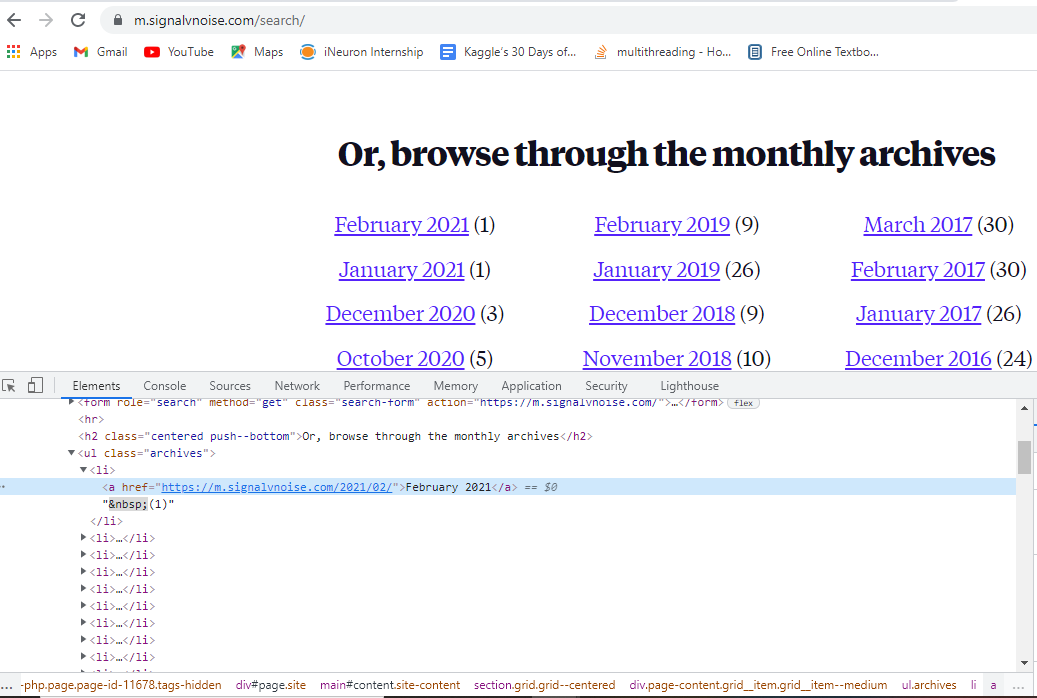

In [60]:
def get_month_titles(doc):
    month_titles_tags = doc.ul.find_all('a')
    month_titles = []
    for tag in month_titles_tags:
        month_titles.append(tag.text)
    return month_titles

get_month_titles can be used to get the list of month titles

In [61]:
titles = get_month_titles(months_doc)

In [62]:
len(titles)

67

In [63]:
titles[:5]

['February 2021',
 'January 2021',
 'December 2020',
 'October 2020',
 'September 2020']

Similarly we have defined function to get each month's url

In [64]:
def get_month_urls(doc):
    month_urls_tags = doc.ul.find_all('a')
    month_urls = []
    for tag in month_urls_tags:
        month_urls.append(tag['href'])
    return month_urls

In [65]:
urls = get_month_urls(months_doc)

In [66]:
len(urls)

67

In [67]:
urls[:5]

['https://m.signalvnoise.com/2021/02/',
 'https://m.signalvnoise.com/2021/01/',
 'https://m.signalvnoise.com/2020/12/',
 'https://m.signalvnoise.com/2020/10/',
 'https://m.signalvnoise.com/2020/09/']

Let's put this all together into a single function which returns dataframe which contains month info

In [68]:
def scrape_months():
    url = 'https://m.signalvnoise.com/search/'
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception('Failed to load page {}'.format(url))
    doc = BeautifulSoup(response.text, 'html.parser')
    months_dict = {
        'Month_Year': get_month_titles(doc),
        'URL': get_month_urls(doc),
    }
    return pd.DataFrame(months_dict)

In [69]:
df = scrape_months()

In [70]:
df.head()

,Month_Year,URL
0,February 2021,https://m.signalvnoise.com/2021/02/
1,January 2021,https://m.signalvnoise.com/2021/01/
2,December 2020,https://m.signalvnoise.com/2020/12/
3,October 2020,https://m.signalvnoise.com/2020/10/
4,September 2020,https://m.signalvnoise.com/2020/09/


### Get the info about all blogs from a month

Let's write a function to download a month page

In [71]:
def get_blogs_page(month_page_url):
    # Download the page
    respons = requests.get(month_page_url)
    # Check successful response
    if respons.status_code != 200:
        raise Exception('Failed to load page {}'.format(month_page_url))
    # Parse using Beautiful soup
    blogs_page_doc = BeautifulSoup(respons.text, 'html.parser')
    return blogs_page_doc

In [72]:
blogs_doc = get_blogs_page('https://m.signalvnoise.com/2021/02/')
blogs_doc

<!DOCTYPE html>

<html lang="en-US">
<head>
<meta charset="utf-8"/>
<meta content="width=device-width, initial-scale=1" name="viewport"/>
<link href="https://gmpg.org/xfn/11" rel="profile"/>
<meta content="noindex, follow" name="robots">
<!-- Jetpack Site Verification Tags -->
<meta content="0DhapiM4O0UOfgAG0h7WKwcen-OnbamAZvubxFltbwE" name="google-site-verification">
<meta content="76FA9A6899F84C58C463EBD43BD0827E" name="msvalidate.01"/>
<!-- This site is optimized with the Yoast SEO plugin v16.9 - https://yoast.com/wordpress/plugins/seo/ -->
<title>February 2021 - Signal v. Noise</title>
<script class="yoast-schema-graph" type="application/ld+json">{"@context":"https://schema.org","@graph":[{"@type":"WebSite","@id":"https://m.signalvnoise.com/#website","url":"https://m.signalvnoise.com/","name":"Signal v. Noise","description":"Strong opinions and shared thoughts on design, business, and tech. By the makers (and friends) of &lt;a href=&quot;https://www.basecamp.com&quot; target=&quot;

To get blog titles and blog urls, we can pick a tags within h2 tags of class 'entry-summary__title'

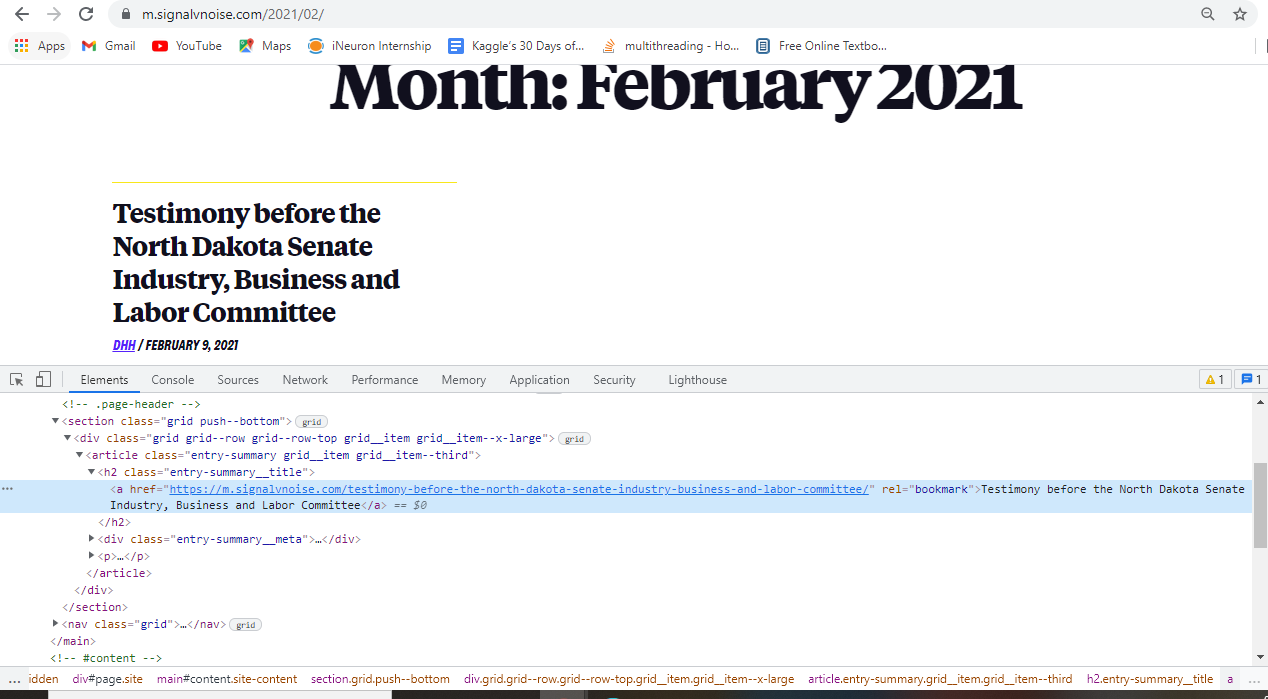

To get author names, we can pick span tags of class 'byline'

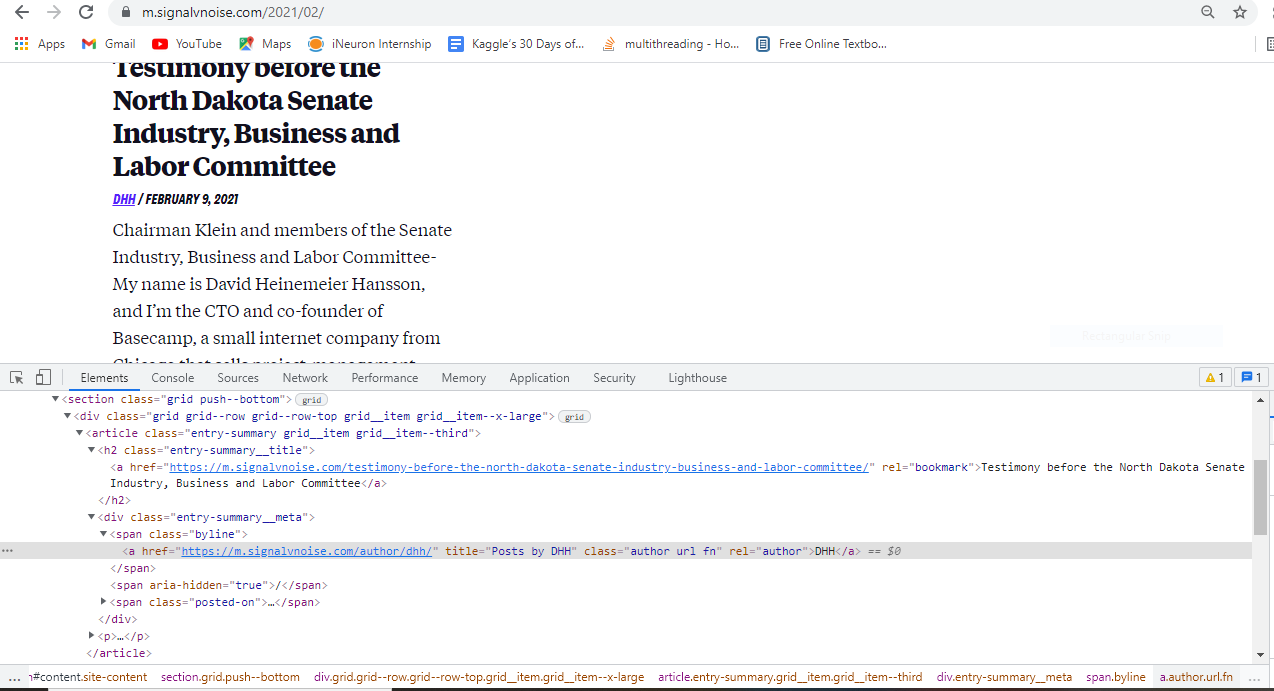

To get published dates, we can pick time tags of class 'entry-date published updated'

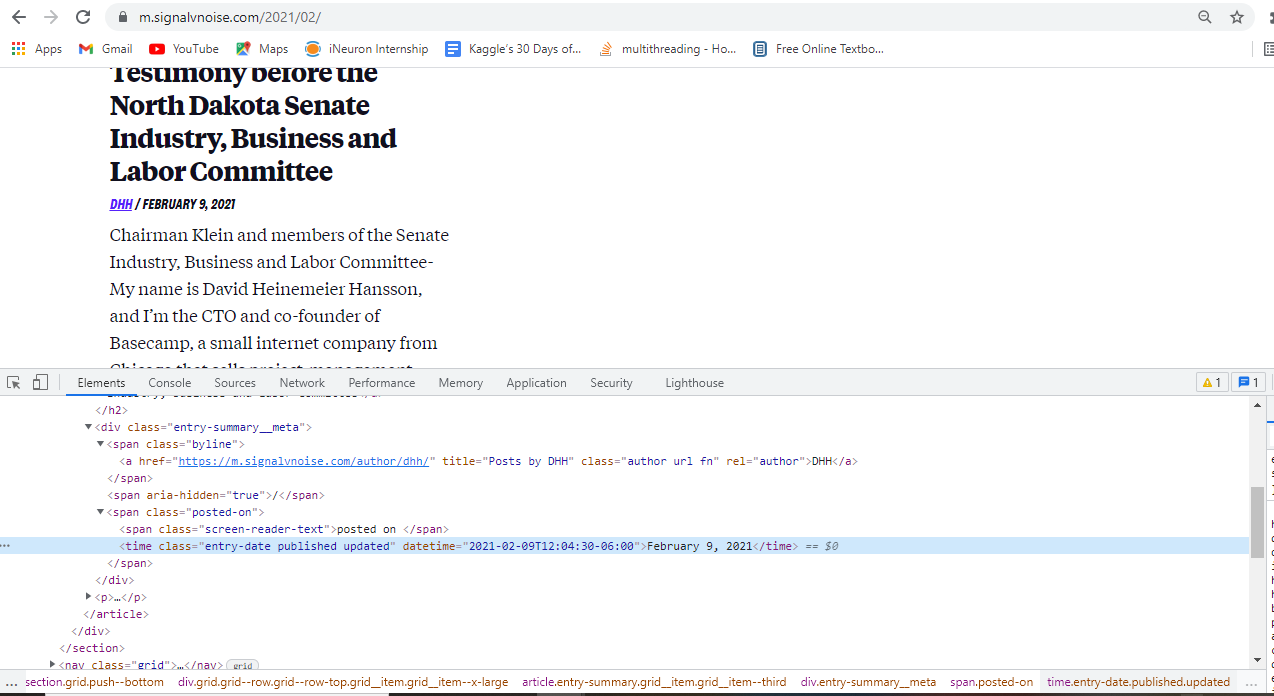

Defining function to get info about all blogs for a month

In [73]:
def get_blog_info(h2_tag, author_tag, date_tag):
    # returns all the required info about a blog
    a_tags = h2_tag.find_all('a')
    title = a_tags[0].text
    url = a_tags[0]['href']
    author = author_tag.text
    date = date_tag.text
    return title, author, date, url


Defining a function which creates the list of blogs

In [74]:
def get_blog(blog_doc):
    # Get h2 tag from which get title tag and url tag
    h2_tags = blog_doc.find_all('h2', {'class': 'entry-summary__title'})
    # Get author tag
    author_tags = blog_doc.find_all('span', {'class': 'byline'})
    # Get date tag
    date_tags = blog_doc.find_all('time', {'class': "entry-date published updated"})
    
#     Creating Dictionary
    blog_dict = {'Title':[], 'Author':[], 'PublishedDate':[], 'URL':[]}
    
    # Get blog info
    for i in range(len(h2_tags)):
        blog_info = get_blog_info(h2_tags[i], author_tags[i], date_tags[i])
        
#         Adding entries to dictionay
        blog_dict['Title'].append(blog_info[0])
        blog_dict['Author'].append(blog_info[1])
        blog_dict['PublishedDate'].append(blog_info[2])
        blog_dict['URL'].append(blog_info[3])
        
    return pd.DataFrame(blog_dict) 

In [76]:
df = get_blog(blogs_doc)

In [78]:
df

,Title,Author,PublishedDate,URL
0,Testimony before the North Dakota Senate Indus...,DHH,"February 9, 2021",https://m.signalvnoise.com/testimony-before-th...


Defining function which creates CSV file for scraped blogs from a month page

In [45]:
def scrape_blog(month_url, path):
#     fname = month_name + '.csv'
    if os.path.exists(path):
        print("The File {} already exists. Skipping.......".format(fname))
        return
    blog_df = get_blog(get_blogs_page(month_url))
    blog_df.to_csv(path, index=None)

Putting it all together
- We have a funciton to get the list of blogs
- We have a function to create a CSV file for scraped blogs from a month page
- Let's create a function to put them together

In [46]:
def scrape_months_blogs():
    print('Scraping list of months')
    months_df = scrape_months()
    
    #creating a folder named 'data'
    os.makedirs('data', exist_ok=True)
    
    # iterating through row of months dataframe
    for index, row in months_df.iterrows():
        print('Scrapping blogs for the {}'.format(row['Month_Year']))
        scrape_blog(row['URL'], 'data/{}.csv'.format(row['Month_Year']))

Let's run it to scrape the blogs for the all the months on the page of https://m.signalvnoise.com/search/

In [47]:
scrape_months_blogs()

Scraping list of months
Scrapping blogs for the February 2021
Scrapping blogs for the January 2021
Scrapping blogs for the December 2020
Scrapping blogs for the October 2020
Scrapping blogs for the September 2020
Scrapping blogs for the August 2020
Scrapping blogs for the July 2020
Scrapping blogs for the June 2020
Scrapping blogs for the May 2020
Scrapping blogs for the April 2020
Scrapping blogs for the March 2020
Scrapping blogs for the February 2020
Scrapping blogs for the January 2020
Scrapping blogs for the December 2019
Scrapping blogs for the November 2019
Scrapping blogs for the October 2019
Scrapping blogs for the September 2019
Scrapping blogs for the August 2019
Scrapping blogs for the July 2019
Scrapping blogs for the June 2019
Scrapping blogs for the May 2019
Scrapping blogs for the April 2019
Scrapping blogs for the March 2019
Scrapping blogs for the February 2019
Scrapping blogs for the January 2019
Scrapping blogs for the December 2018
Scrapping blogs for the November 

We can check that the CSVs were created properly

# Summary and References

Summary of what we did
- Firstly, we scraped all months.
- Secondly, we scraped the blogs for each month and stores info about that blog in a dataframe
- Finally, we created a CSV file for scraped blogs from a month page 

References to links you found useful
- https://www.crummy.com/software/BeautifulSoup/bs4/doc/
- https://stackoverflow.com/